In [70]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


# Showcase

## 1 DENSE/cine displacment prediction std

In [71]:
# load data

In [72]:
# showcase data indices
DENSE_showcase_indices = [85, 1]
DENSE_showcase_data_fnames = [
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-085-UVA_05192021-76.npy',
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-001-033-86.npy'
]
DENSE_showcase_data_skipdiffusion_fnames = [
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-085-UVA_05192021-76.npy',
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-001-033-86.npy'
]
DENSE_showcase_ES_frame = [22, 24]
cine_showcase_indices = [86, 74]
cine_showcase_data_fnames = [
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/cine/LaMoD-cine-086-UVA04--36.npy',
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/cine/LaMoD-cine-074-124-47.npy'
]
# cine_showcase_ES_frame = [22, 24]
cine_showcase_data_skipdiffusion_fnames = [
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/cine/LaMoD-cine-SkipDiffusion-086-UVA04--36.npy',
    '/scratch/jx8fh/2025-01-04-LaMoD-variability/cine/LaMoD-cine-SkipDiffusion-074-124-47.npy'
]

In [73]:
end_sys_DENSE_frame_indices = {
    '033': 24,#
    '122': 26,#
    '124': 22,#
    '125': 22,#
    '136': 26,#
    '146': 19,#
    '17': 20,
    'CRT104': 22,
    'CT01': 12,#
    'CT03': 12,
    'CT22': 12,#
    'CT40': 8,
    'Emory_04': 20,#
    'Emory_06': 20,#
    'Emory_07': 20,#
    'Lyon69_ene_al': 25,
    'Lyon_Cha_Jea': 20,
    'Lyon_Ene_Alex': 22,
    'Lyon_d04_scanA': 22,
    'OB015': 20,#
    'OB016': 17,#
    'OB017': 17,#
    'OB018': 17,#
    'OB019': 17,#
    'P117': 20,
    'StFrancis_DENSE10A': 22,
    'StFrancis_DENSE11A': 22,
    'UVA_04': 25,#
    'UVA_05': 20,#
    'UVA_05192021': 22,
    'UVA_07': 22,# 20->22
    'UVA_08_A_U1': 22,#
    'UVA_09_A_U1': 22,#
    'UVA_11_A_U1': 25,#
}

LMA_flag = {
    '033': True,
    '122': True,
    '124': True,
    '125': True,
    '136': True,
    '146': True,
    '17': False,
    'CRT104': True,
    'CT01': True,
    'CT03': False,
    'CT22': False,
    'CT40': True,
    'Emory_04': False,
    'Emory_06': False,
    'Emory_07': False,
    'Lyon69_ene_al': False,
    'Lyon_Cha_Jea': True,
    'Lyon_Ene_Alex': False,
    'Lyon_d04_scanA': False,
    'OB015': False,
    'OB016': False,
    'OB017': True,
    'OB018': False,
    'OB019': False,
    'P117': True,
    'StFrancis_DENSE10A': False,
    'StFrancis_DENSE11A': False,
    'UVA_04': False,
    'UVA_05': False,
    'UVA_05192021': False,
    'UVA_07': False,
    'UVA_08_A_U1': False,
    'UVA_09_A_U1': False,
    'UVA_11_A_U1': False,
}

In [89]:
# Load data
DENSE_showcase_data_preds = [np.load(fname, allow_pickle=True).tolist() for fname in DENSE_showcase_data_fnames]
DENSE_showcase_data_skipdiffusion_preds = [np.load(fname, allow_pickle=True).tolist() for fname in DENSE_showcase_data_skipdiffusion_fnames]
cine_showcase_data_preds = [np.load(fname, allow_pickle=True).tolist() for fname in cine_showcase_data_fnames]
cine_showcase_data_skipdiffusion_preds = [np.load(fname, allow_pickle=True).tolist() for fname in cine_showcase_data_skipdiffusion_fnames]

In [75]:
DENSE_showcase_data_fnames

['/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-085-UVA_05192021-76.npy',
 '/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-001-033-86.npy']

In [76]:
segment_names = [
    'Inferoseptal',
    'Inferior',
    'Inferolateral',
    'Anterolateral',
    'Anterior',
    'Anteroseptal'
]

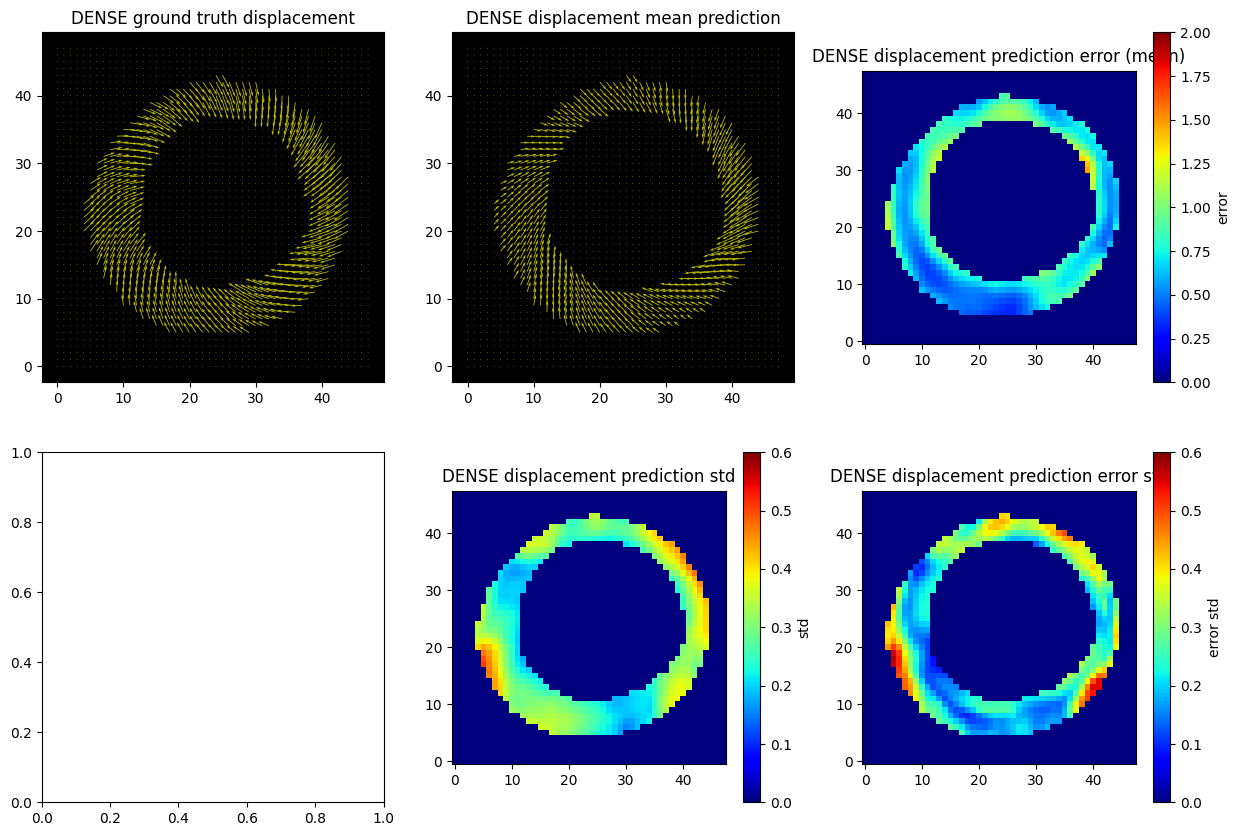

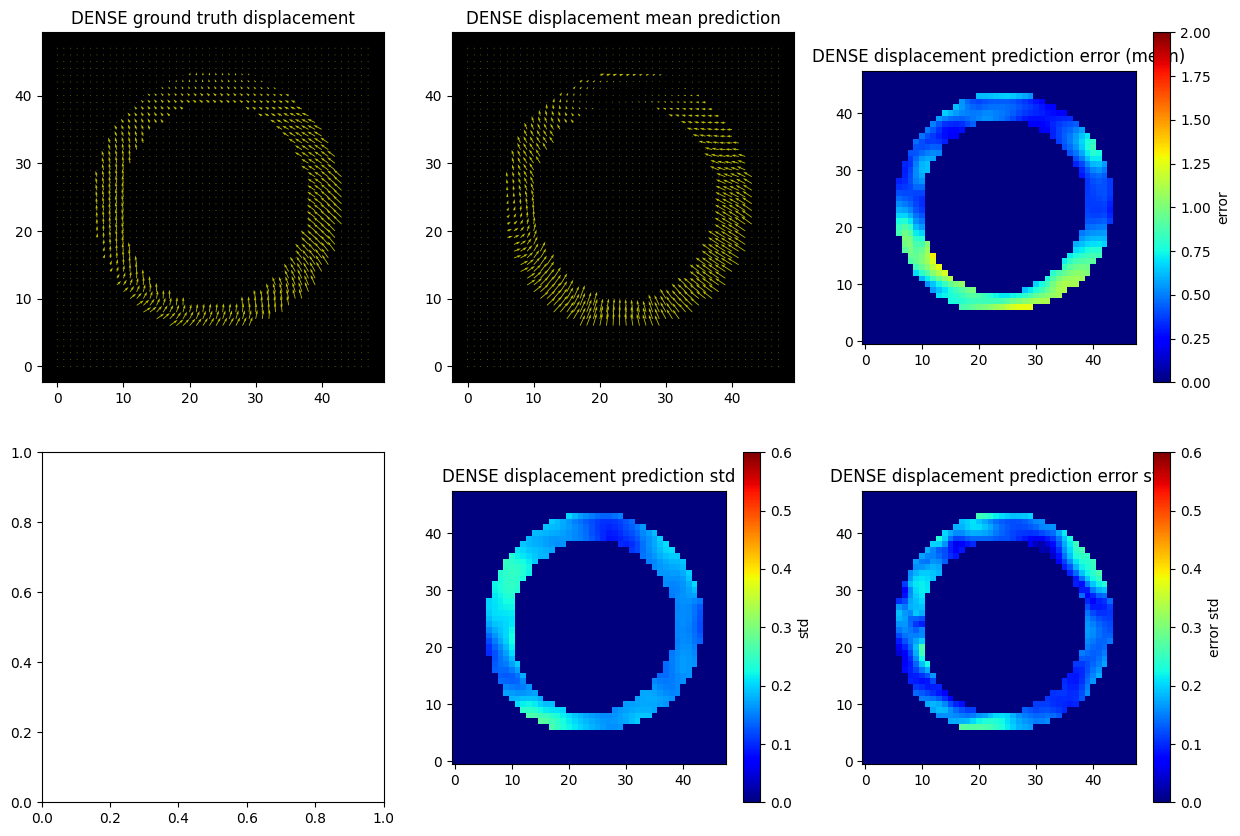

In [77]:
# DENSE showcase displacement prediction std and displacement prediction error std
def epe_error(output, target):
    epe = np.sqrt(((output[:, 0, :, :, :] - target[:, 0, :, :, :])**2.0 
                 + (output[:, 1, :, :, :] - target[:, 1, :, :, :])**2.0))
    return epe
for preds_idx, preds in enumerate(DENSE_showcase_data_preds):
    pred_disps = [datum['disp_pred']*1.5 for datum in preds]
    gt_disps = [datum['disp_GT'][...,:-1] for datum in preds]
    
    pred_disps_std = np.mean(np.std(pred_disps, axis=0), axis=0)
    pred_pixelwise_mean_error = np.mean([epe_error(pred[None], gt[None])[None] for pred, gt in zip(pred_disps, gt_disps)], axis=0)
    pred_pixelwise_error_std = np.std([epe_error(pred[None], gt[None])[None] for pred, gt in zip(pred_disps, gt_disps)], axis=0)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    # GT Displacement Field
    axs[0,0].quiver(
        gt_disps[0][0,...,10],
        gt_disps[0][1,...,10],
        scale=1,
        units='xy',
        color='y')
    # set black background
    axs[0,0].set_facecolor('black')
    axs[0,0].set_title('DENSE ground truth displacement')

    # Mean Predicted Displacement Field
    pred_disps_mean_X = np.mean([disp[0] for disp in pred_disps], axis=0)#*1.5
    pred_disps_mean_Y = np.mean([disp[1] for disp in pred_disps], axis=0)#*1.5
    axs[0,1].quiver(
        pred_disps_mean_X[...,10], 
        pred_disps_mean_Y[...,10],
        scale=1,
        units='xy',
        color='y',
    )
    # set black background
    axs[0,1].set_facecolor('black')
    axs[0,1].set_title('DENSE displacement mean prediction')

    # Predicted Displacement Field std
    axs[1,1].imshow(pred_disps_std[...,10], cmap='jet', vmin=0, vmax=0.6)
    axs[1,1].set_title('DENSE displacement prediction std')
    axs[1,1].invert_yaxis()
    # show colorbar
    cbar = fig.colorbar(axs[1,1].images[0])
    cbar.set_label('std')
    # make background black
    # axs[1,0].set_facecolor('black')

    

    # Predicted Displacement Field error (mean vs GT)
    axs[0,2].imshow(pred_pixelwise_mean_error[0,0,...,10], cmap='jet', vmin=0, vmax=2)
    axs[0,2].set_title('DENSE displacement prediction error (mean)')
    axs[0,2].invert_yaxis()
    # show colorbar
    cbar = fig.colorbar(axs[0,2].images[0])
    cbar.set_label('error')


    # Predicted Displacement Field error std
    axs[1,2].imshow(pred_pixelwise_error_std[0,0,...,10], cmap='jet', vmin=0, vmax=0.6)
    axs[1,2].set_title('DENSE displacement prediction error std')
    axs[1,2].invert_yaxis()
    # show colorbar
    cbar = fig.colorbar(axs[1,2].images[0])
    cbar.set_label('error std')

In [78]:
check_dict(cine_showcase_data_preds[0][0])

disp_GT                                                      (2, 48, 48, 45)     
disp_pred                                                    (2, 48, 48, 24)     
strain_GT                                                    (48, 48, 45)        
strain_pred                                                  (48, 48, 24)        
origin_pred                                                  (2,)                
insertion_pred                                               (2,)                
CCs4_pred                                                    (4, 24)             
CCs6_pred                                                    (6, 24)             
CCs18_pred                                                   (18, 24)            
Seg4_pred                                                    dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
Seg6_pred                                                    dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID']

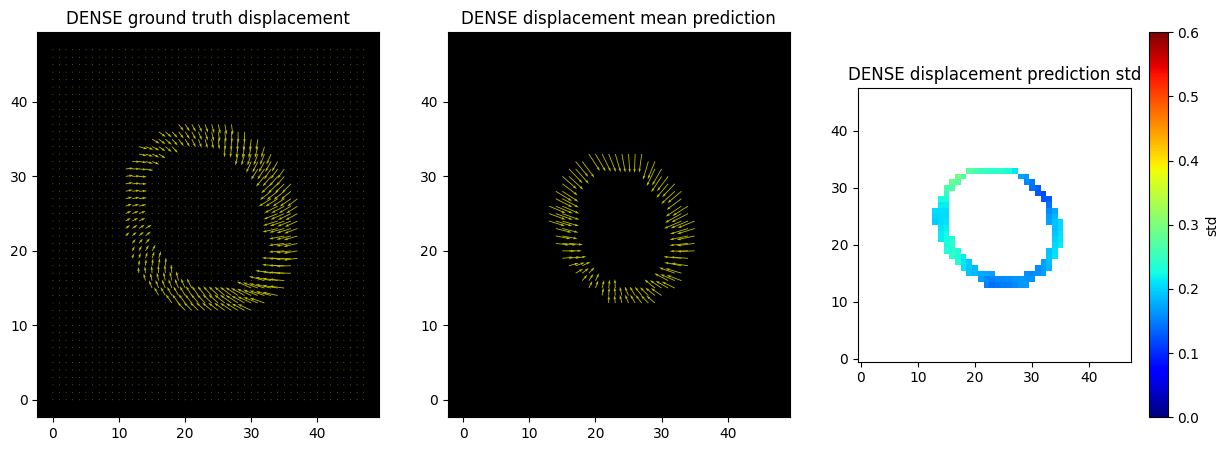

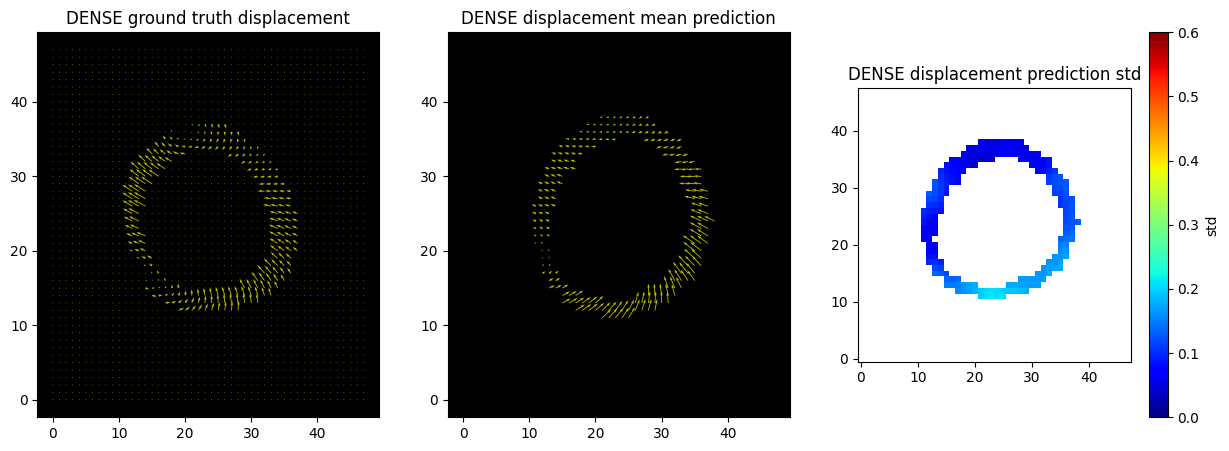

In [79]:
# cine showcase displacement prediction std
# def epe_error(output, target):
#     epe = np.sqrt(((output[:, 0, :, :, :] - target[:, 0, :, :, :])**2.0 
#                  + (output[:, 1, :, :, :] - target[:, 1, :, :, :])**2.0))
#     return epe
for preds_idx, preds in enumerate(cine_showcase_data_preds):
    pred_disps = [datum['disp_pred'] for datum in preds]
    gt_disps = [datum['disp_GT'][...,:-1] for datum in preds]
    
    pred_disps_std = np.mean(np.std(pred_disps, axis=0), axis=0)
    # pred_pixelwise_mean_error = np.mean([epe_error(pred[None], gt[None])[None] for pred, gt in zip(pred_disps, gt_disps)], axis=0)
    # pred_pixelwise_error_std = np.std([epe_error(pred[None], gt[None])[None] for pred, gt in zip(pred_disps, gt_disps)], axis=0)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.reshape((1,3))

    # GT Displacement Field
    axs[0,0].quiver(
        gt_disps[0][0,...,10],
        gt_disps[0][1,...,10],
        scale=1,
        units='xy',
        color='y')
    # set black background
    axs[0,0].set_facecolor('black')
    axs[0,0].set_title('DENSE ground truth displacement')

    # Mean Predicted Displacement Field
    pred_disps_mean_X = np.mean([disp[0] for disp in pred_disps], axis=0)
    pred_disps_mean_Y = np.mean([disp[1] for disp in pred_disps], axis=0)
    axs[0,1].quiver(
        pred_disps_mean_X[...,10], 
        pred_disps_mean_Y[...,10],
        scale=1,
        units='xy',
        color='y',
    )
    # set black background
    axs[0,1].set_facecolor('black')
    axs[0,1].set_title('DENSE displacement mean prediction')

    # Predicted Displacement Field std
    axs[0,2].imshow(pred_disps_std[...,10], cmap='jet', vmin=0, vmax=0.6)
    axs[0,2].set_title('DENSE displacement prediction std')
    axs[0,2].invert_yaxis()
    # show colorbar
    cbar = fig.colorbar(axs[0,2].images[0])
    cbar.set_label('std')

# DENSE/cine showcase
disp Pred Strain Pred strain curves
disp GT   Strain GT

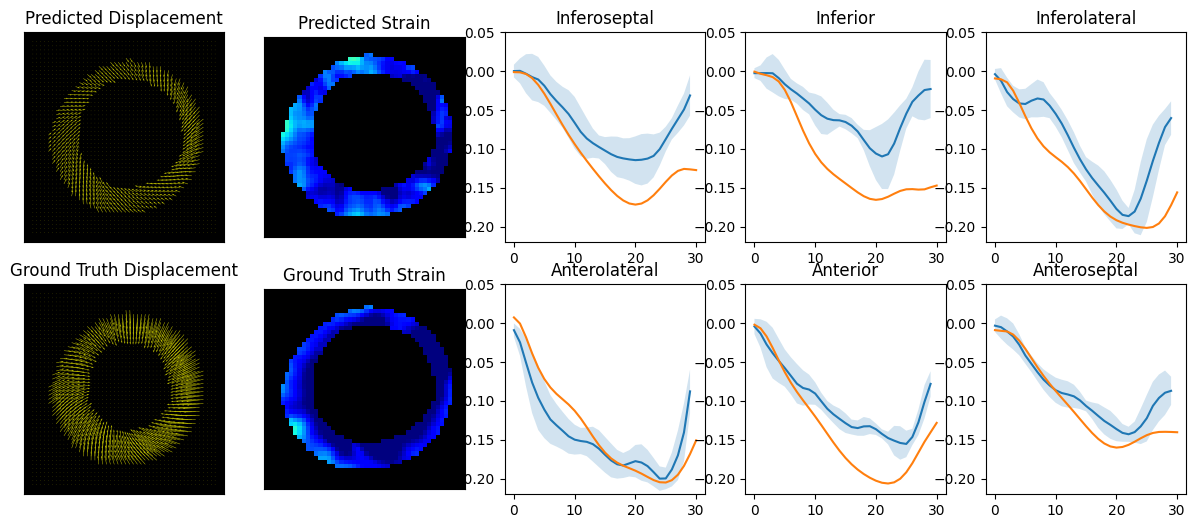

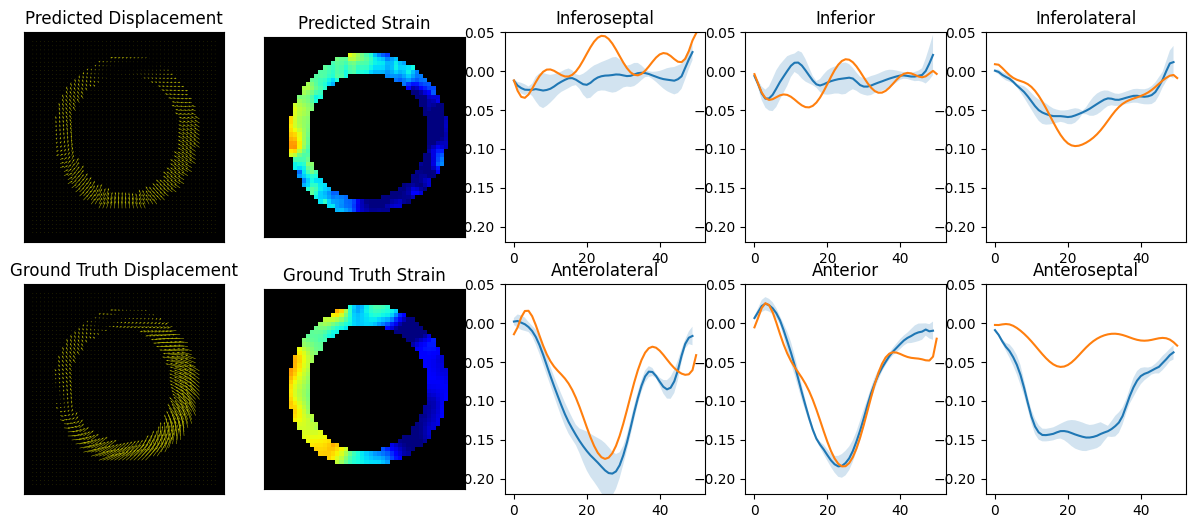

In [80]:
for preds_idx, preds in enumerate(DENSE_showcase_data_preds):
    pred_disps = [datum['disp_pred']*1.5 for datum in preds]
    pred_disp_skipdiffusion = [datum['disp_pred']*1.5 for datum in DENSE_showcase_data_skipdiffusion_preds[preds_idx]][0]
    gt_disps = [datum['disp_GT'][...,:-1] for datum in preds]

    # datum_patient_id = test_DENSE_data[check_datum_idx]['patient_id']
    datum_ES_frame = DENSE_showcase_ES_frame[preds_idx]
    # datum_ES_time = test_DENSE_data[check_datum_idx]['DENSE_frame_time_stamps'][datum_ES_frame]
    

    pred_disps_mean_X = np.mean([disp[0] for disp in pred_disps], axis=0)#*1.5
    pred_disps_mean_Y = np.mean([disp[1] for disp in pred_disps], axis=0)#*1.5

    pred_strains = [datum['strain_pred']*1.5 for datum in preds]
    pred_strain_mean = np.mean([strain for strain in pred_strains], axis=0)
    # pred_strain_mean = preds[0]['strain_pred']*1.5
    pred_strain_skipdiffusion = [datum['strain_pred']*1.5 for datum in DENSE_showcase_data_skipdiffusion_preds[preds_idx]][0]
    gt_strain = preds[0]['strain_GT']

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    # Predicted Displacements Field
    axs[0,0].quiver(
        pred_disps_mean_X[...,10], 
        pred_disps_mean_Y[...,10], 
        color='y', 
        scale=1,
        scale_units='xy')
    axs[0,0].set_title('Predicted Displacement')
    axs[0,0].set_facecolor('black')
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])

    # GT Displacements Field
    axs[1,0].quiver(
        gt_disps[0][0,...,datum_ES_frame],
        gt_disps[0][1,...,datum_ES_frame],
        color='y',
        scale=1,
        scale_units='xy')
    axs[1,0].set_title('Ground Truth Displacement')
    axs[1,0].set_facecolor('black')
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])

    # Predicted Strain Image
    axs[0,1].imshow(pred_strain_mean[...,datum_ES_frame], cmap='jet', vmin=-0.2, vmax=0.2)
    # axs[0,1].imshow(pred_strain_skipdiffusion[...,10], cmap='jet', vmin=-0.2, vmax=0.2)
    axs[0,1].set_title('Predicted Strain')
    axs[0,1].set_facecolor('black')
    axs[0,1].invert_yaxis()
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])
    # colorbar
    # cbar = fig.colorbar(axs[0,1].images[0], ax=axs[0,1])
    # cbar.set_label('Strain')

    # GT Strain Image
    axs[1,1].imshow(gt_strain[...,datum_ES_frame], cmap='jet', vmin=-0.2, vmax=0.2)
    axs[1,1].set_title('Ground Truth Strain')
    axs[1,1].set_facecolor('black')
    axs[1,1].invert_yaxis()
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    # colorbar
    # cbar = fig.colorbar(axs[1,1].images[0], ax=axs[1,1])
    # cbar.set_label('Strain')

    # Strain curves
    n_sectors = 6
    # fig, axs = plt.subplots(2, n_sectors, figsize=(n_sectors*2, 5))
    for sector_idx in range(n_sectors):
        row_idx = sector_idx // 3
        col_idx = sector_idx % 3
        sector_strain_curves_pred_mean = np.mean([pred['CCs6_pred'][sector_idx]*1.5 for pred in preds], axis=0)
        sector_strain_curves_pred_std = np.std([pred['CCs6_pred'][sector_idx]*1.5 for pred in preds], axis=0)

        sector_strain_curves_GT_mean = np.mean([pred['CCs6_GT'][sector_idx] for pred in preds], axis=0)
        # sector_strain_curves_GT_std = np.std([pred['CCs6_GT'][sector_idx] for pred in trial_data], axis=0)

        axs[row_idx, col_idx+2].plot(sector_strain_curves_pred_mean, label='Predicted')
        axs[row_idx, col_idx+2].fill_between(np.arange(len(sector_strain_curves_pred_mean)), sector_strain_curves_pred_mean - sector_strain_curves_pred_std, sector_strain_curves_pred_mean + sector_strain_curves_pred_std, alpha=0.2)
        axs[row_idx, col_idx+2].plot(sector_strain_curves_GT_mean, label='Ground Truth')
        # axs[0, sector_idx].fill_between(np.arange(len(sector_strain_curves_GT_mean)), sector_strain_curves_GT_mean - sector_strain_curves_GT_std, sector_strain_curves_GT_mean + sector_strain_curves_GT_std, alpha=0.2)

        # set the y-axis between -0.25 and 0.05
        axs[row_idx, col_idx+2].set_ylim([-0.22, 0.05])
        axs[row_idx, col_idx+2].set_title(f'{segment_names[sector_idx]}')


In [81]:
from skimage.transform import resize
from copy import deepcopy
def zoom_img(image, scale=1.0):
    # rescale image and crop / pad to keep original shape
    h, w = image.shape[:2]
    new_h = int(h * scale)
    new_w = int(w * scale)

    left_pad = (new_w - w) // 2
    right_pad = (new_w - w) - left_pad
    top_pad = (new_h - h) // 2
    bottom_pad = (new_h - h) - top_pad

    image_resize = resize(image, (new_h, new_w), order=3)
    image_resize_crop = image_resize[top_pad:new_h - bottom_pad, left_pad:new_w - right_pad]
    return image_resize_crop

def zoom_img_with_nan(image_raw, scale=1.0):
    image = deepcopy(image_raw)
    # rescale image and crop / pad to keep original shape
    h, w = image.shape[:2]
    new_h = int(h * scale)
    new_w = int(w * scale)
    
    left_pad = (new_w - w) // 2
    right_pad = (new_w - w) - left_pad
    top_pad = (new_h - h) // 2
    bottom_pad = (new_h - h) - top_pad

    # print(left_pad, right_pad, top_pad, bottom_pad)
    nan_mask = np.isnan(image)
    # nan_mask = image<0.5
    image[nan_mask] = 0.0
    # print(np.sum(np.isnan(image)))

    image_resize = resize(image, (new_h, new_w), order=3)    
    # print(image_resize.max())
    image_resize_crop = image_resize[top_pad:new_h - bottom_pad, left_pad:new_w - right_pad]

    mask_resize = resize(nan_mask.astype(float), (new_h, new_w), order=3)
    mask_resize_crop = mask_resize[top_pad:new_h - bottom_pad, left_pad:new_w - right_pad]
    # mask_resize_crop = mask_resize_crop.astype(np.bool)
    image_resize_crop[mask_resize_crop > 0.5] = np.nan
    return image_resize_crop
    # return nan_mask
# plt.imshow(zoom_img_with_nan(pred_strain_mean[...,datum_ES_frame], 1.1))

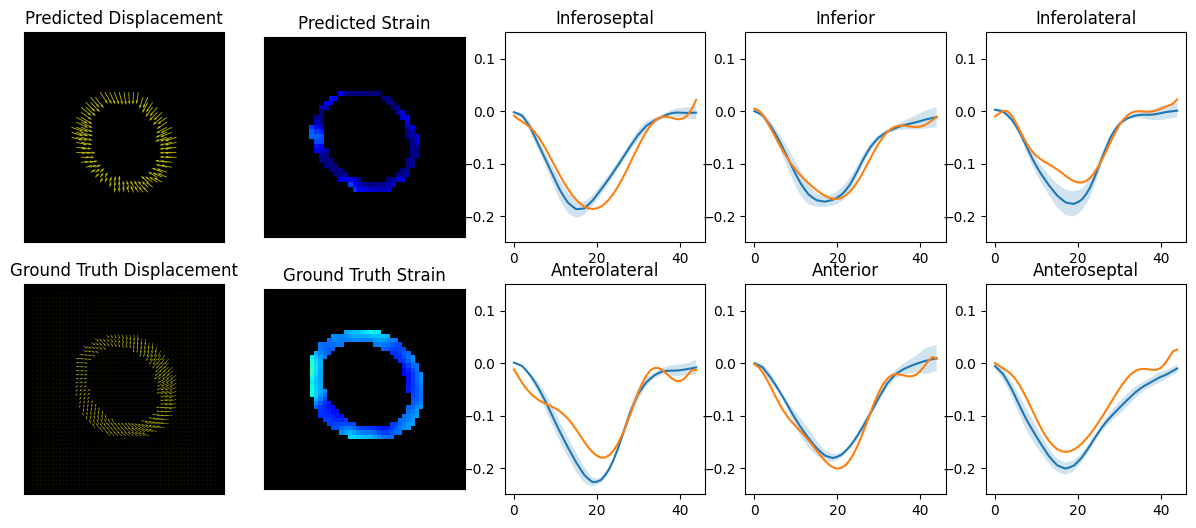

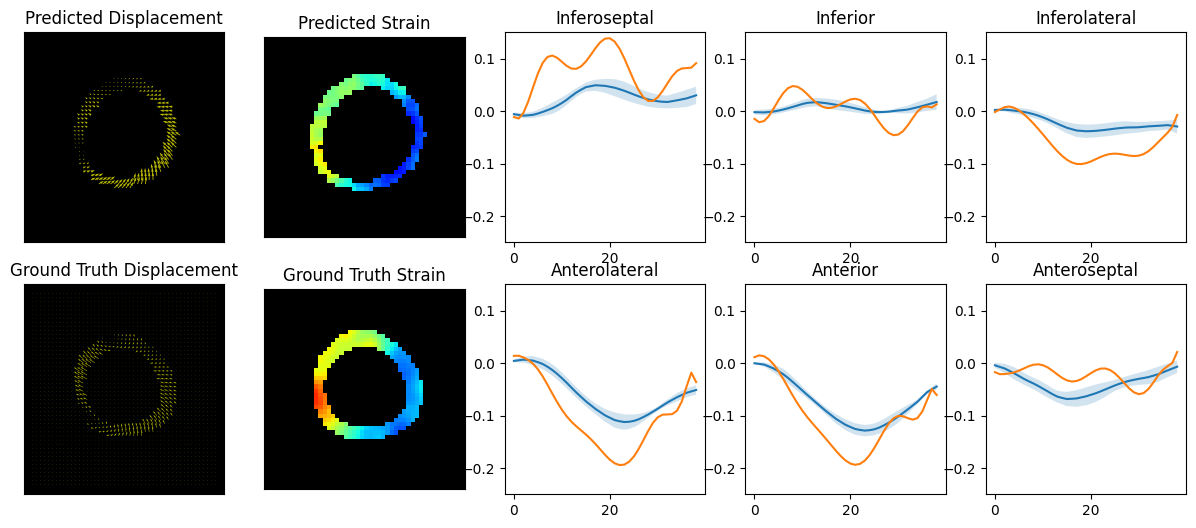

In [98]:
for preds_idx, preds in enumerate(cine_showcase_data_preds):
    pred_disps = [datum['disp_pred'] for datum in preds]
    # pred_disp_skipdiffusion = [datum['disp_pred']*1.5 for datum in DENSE_showcase_data_skipdiffusion_preds[preds_idx]][0]
    gt_disps = [datum['disp_GT'][...,:-1] for datum in preds]

    # datum_patient_id = test_DENSE_data[check_datum_idx]['patient_id']
    datum_ES_frame = 10
    # datum_ES_time = test_DENSE_data[check_datum_idx]['DENSE_frame_time_stamps'][datum_ES_frame]
    

    pred_disps_mean_X = np.mean([disp[0] for disp in pred_disps], axis=0)#*1.5
    pred_disps_mean_Y = np.mean([disp[1] for disp in pred_disps], axis=0)#*1.5

    pred_strains = [datum['strain_pred'] for datum in preds]
    pred_strain_mean = np.mean([strain for strain in pred_strains], axis=0)
    # pred_strain_mean = preds[0]['strain_pred']*1.5
    # pred_strain_skipdiffusion = [datum['strain_pred']*1.5 for datum in DENSE_showcase_data_skipdiffusion_preds[preds_idx]][0]
    gt_strain = preds[0]['strain_GT']

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    # Predicted Displacements Field
    axs[0,0].quiver(
        pred_disps_mean_X[...,10]*preds[0]['mask_raw'].numpy(), 
        pred_disps_mean_Y[...,10]*preds[0]['mask_raw'].numpy(), 
        # zoom_img_with_nan(pred_disps_mean_X[...,10], 1.5), 
        # zoom_img_with_nan(pred_disps_mean_Y[...,10], 1.5), 
        color='y', 
        scale=1,
        width=0.004,
        scale_units='xy')
    axs[0,0].set_title('Predicted Displacement')
    axs[0,0].set_facecolor('black')
    if preds_idx == 0:
        axs[0,0].set_ylim(3, 45)
        axs[0,0].set_xlim(3, 45)
    # hide axis
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])


    # GT Displacements Field
    axs[1,0].quiver(
        gt_disps[0][0,...,datum_ES_frame],
        gt_disps[0][1,...,datum_ES_frame],
        color='y',
        scale=1,
        scale_units='xy')
    axs[1,0].set_title('Ground Truth Displacement')
    axs[1,0].set_facecolor('black')
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])

    # Predicted Strain Image
    pred_strain_mean_vis_frame = deepcopy(pred_strain_mean[...,datum_ES_frame])
    pred_strain_mean_vis_frame[preds[0]['mask_raw'].numpy()<0.5] = np.nan
    # axs[0,1].imshow(zoom_img_with_nan(pred_strain_mean[...,datum_ES_frame]*preds[0]['mask_raw'].numpy(), 1.2), cmap='jet', vmin=-0.2, vmax=0.2)
    axs[0,1].imshow(pred_strain_mean_vis_frame, cmap='jet', vmin=-0.2, vmax=0.2)
    # axs[0,1].imshow(pred_strain_skipdiffusion[...,10], cmap='jet', vmin=-0.2, vmax=0.2)
    axs[0,1].set_title('Predicted Strain')
    axs[0,1].set_facecolor('black')
    axs[0,1].invert_yaxis()
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])
    if preds_idx == 0:
        axs[0,1].set_ylim(3, 45)
        axs[0,1].set_xlim(3, 45)
    # colorbar
    # cbar = fig.colorbar(axs[0,1].images[0], ax=axs[0,1])
    # cbar.set_label('Strain')

    # GT Strain Image
    axs[1,1].imshow(gt_strain[...,datum_ES_frame], cmap='jet', vmin=-0.2, vmax=0.2)
    axs[1,1].set_title('Ground Truth Strain')
    axs[1,1].set_facecolor('black')
    axs[1,1].invert_yaxis()
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    # colorbar
    # cbar = fig.colorbar(axs[1,1].images[0], ax=axs[1,1])
    # cbar.set_label('Strain')

    # Strain curves
    n_sectors = 6
    # fig, axs = plt.subplots(2, n_sectors, figsize=(n_sectors*2, 5))
    for sector_idx in range(n_sectors):
        row_idx = sector_idx // 3
        col_idx = sector_idx % 3
        sector_strain_curves_pred_mean = np.mean([pred['CCs6Resampled_pred'][sector_idx] for pred in preds], axis=0)
        sector_strain_curves_pred_std = np.std([pred['CCs6Resampled_pred'][sector_idx] for pred in preds], axis=0)

        sector_strain_curves_GT_mean = np.mean([pred['CCs6_GT'][sector_idx] for pred in preds], axis=0)
        # sector_strain_curves_GT_std = np.std([pred['CCs6_GT'][sector_idx] for pred in trial_data], axis=0)

        axs[row_idx, col_idx+2].plot(sector_strain_curves_pred_mean, label='Predicted')
        axs[row_idx, col_idx+2].fill_between(np.arange(len(sector_strain_curves_pred_mean)), sector_strain_curves_pred_mean - sector_strain_curves_pred_std, sector_strain_curves_pred_mean + sector_strain_curves_pred_std, alpha=0.2)
        axs[row_idx, col_idx+2].plot(sector_strain_curves_GT_mean, label='Ground Truth')
        # axs[0, sector_idx].fill_between(np.arange(len(sector_strain_curves_GT_mean)), sector_strain_curves_GT_mean - sector_strain_curves_GT_std, sector_strain_curves_GT_mean + sector_strain_curves_GT_std, alpha=0.2)

        # set the y-axis between -0.25 and 0.05
        axs[row_idx, col_idx+2].set_ylim([-0.25, 0.15])
        axs[row_idx, col_idx+2].set_title(f'{segment_names[sector_idx]}')

In [92]:
preds[0].keys()

dict_keys(['disp_GT', 'disp_pred', 'strain_GT', 'strain_pred', 'mask_raw', 'mask', 'origin_pred', 'insertion_pred', 'CCs4_pred', 'CCs6_pred', 'CCs18_pred', 'Seg4_pred', 'Seg6_pred', 'Seg18_pred', 'CCs4Resampled_pred', 'CCs6Resampled_pred', 'CCs18Resampled_pred', 'origin_GT', 'insertion_GT', 'CCs4_GT', 'CCs6_GT', 'CCs18_GT', 'Seg4_GT', 'Seg6_GT', 'Seg18_GT', 'layerid_map_GT', 'CCs4_endo_GT', 'CCs6_endo_GT', 'CCs18_endo_GT', 'CCs4_mid_GT', 'CCs6_mid_GT', 'CCs18_mid_GT', 'CCs4_epi_GT', 'CCs6_epi_GT', 'CCs18_epi_GT', 'CCs4Resampled_GT', 'CCs6Resampled_GT', 'CCs18Resampled_GT'])

In [93]:
preds[0]['mask_raw'].shape

torch.Size([48, 48])

# Quantative

In [30]:
import glob
# all_DENSE_data_fnames: all files with name /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-* and does not contain "SkipDiffusion"
all_DENSE_data_fnames = glob.glob("/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-*")
all_DENSE_data_fnames = [fname for fname in all_DENSE_data_fnames if "SkipDiffusion" not in fname]

all_cine_data_fnames = glob.glob("/scratch/jx8fh/2025-01-04-LaMoD-variability/cine/LaMoD-cine-*")
all_cine_data_fnames = [fname for fname in all_cine_data_fnames if "SkipDiffusion" not in fname]

In [31]:
all_DENSE_data = [np.load(f, allow_pickle=True).tolist() for f in all_DENSE_data_fnames]
all_cine_data = [np.load(f, allow_pickle=True).tolist() for f in all_cine_data_fnames]

In [49]:
[[]]*6

[[], [], [], [], [], []]

In [53]:
# for each segment, collect the std s from all the patients
segmental_stds = [[],[],[],[],[],[]]

global_strain_stds = []
for preds in all_DENSE_data:
    global_strain_std = np.mean(np.std([pred['CCs6_pred'] for pred in preds], axis=0))
    global_strain_stds.append(global_strain_std)

    
    for sector_idx in range(6):
        sector_strain_curves_pred_std = np.mean(np.std([pred['CCs6_pred'][sector_idx] for pred in preds], axis=0))
        segmental_stds[sector_idx].append(sector_strain_curves_pred_std)


Text(0.5, 1.0, 'Segmental Strain Standard Deviations (DENSE)')

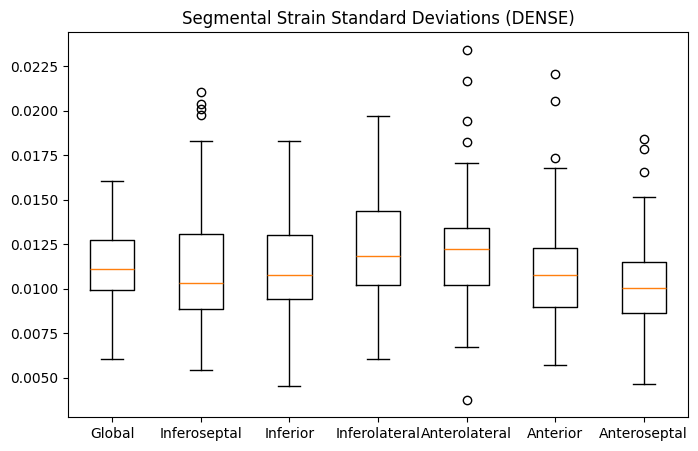

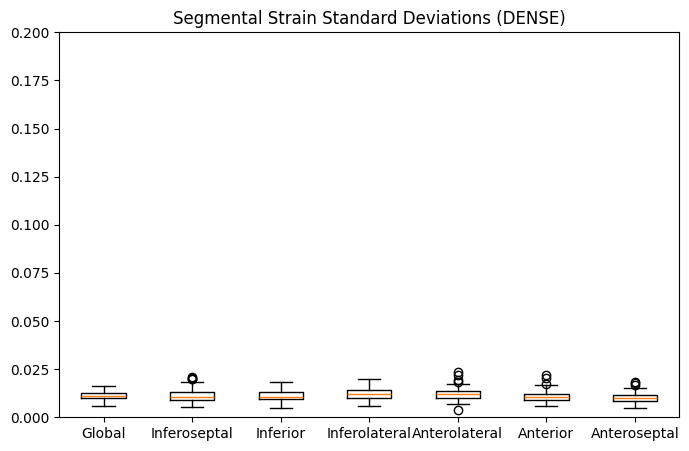

In [87]:
# make a boxplot of the data
fig, axe = plt.subplots(1,1, figsize=(8, 5))
box_names = ['Global', *segment_names]
_ = axe.boxplot(
    [global_strain_stds, *segmental_stds],
    labels=box_names,
)
axe.set_title('Segmental Strain Standard Deviations (DENSE)')

# make a boxplot of the data
fig, axe = plt.subplots(1,1, figsize=(8, 5))
box_names = ['Global', *segment_names]
_ = axe.boxplot(
    [global_strain_stds, *segmental_stds],
    labels=box_names,)
axe.set_ylim(0, 0.2)
axe.set_title('Segmental Strain Standard Deviations (DENSE)')

In [59]:
cine_segmental_stds = [[],[],[],[],[],[]]

cine_global_strain_stds = []
for cine_preds in all_cine_data:
    cine_global_strain_std = np.mean(np.std([pred['CCs6_pred'] for pred in cine_preds], axis=0))
    cine_global_strain_stds.append(cine_global_strain_std)

    
    for sector_idx in range(6):
        cine_sector_strain_curves_pred_std = np.mean(np.std([pred['CCs6_pred'][sector_idx] for pred in cine_preds], axis=0))
        cine_segmental_stds[sector_idx].append(cine_sector_strain_curves_pred_std)

Text(0.5, 1.0, 'Segmental Strain Standard Deviations (cine)')

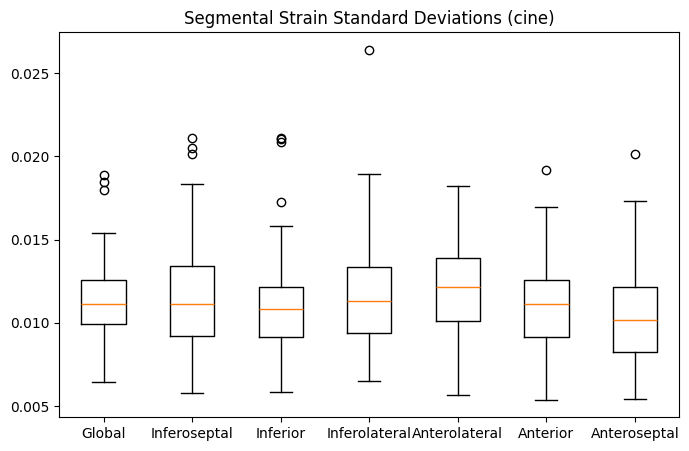

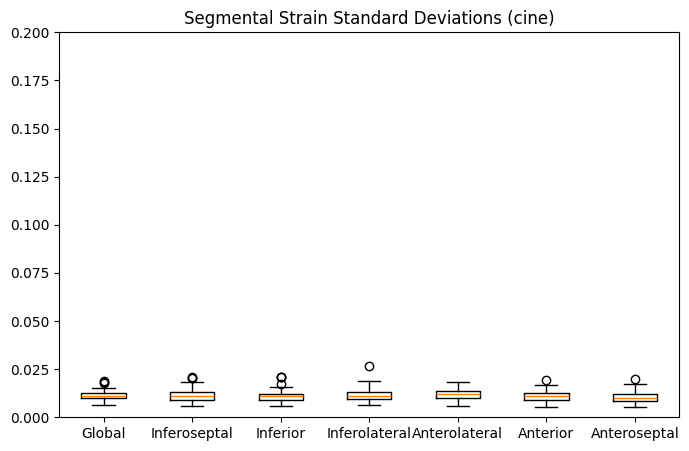

In [88]:
# make a boxplot of the data
fig, axe = plt.subplots(1,1, figsize=(8, 5))
box_names = ['Global', *segment_names]
_ = axe.boxplot(
    [cine_global_strain_stds, *cine_segmental_stds],
    labels=box_names,)
axe.set_title('Segmental Strain Standard Deviations (cine)')

# make a boxplot of the data
fig, axe = plt.subplots(1,1, figsize=(8, 5))
box_names = ['Global', *segment_names]
_ = axe.boxplot(
    [cine_global_strain_stds, *cine_segmental_stds],
    labels=box_names,)
axe.set_ylim(0, 0.2)
axe.set_title('Segmental Strain Standard Deviations (cine)')